In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras import Sequential
from keras.src.layers import LSTM, Dense
from random import randint

In [3]:
def get_df(data_size:int=500, path:str="..\..\Data\AAPL_stock_prices.csv", delimeter: str = ',', from_end: bool = True, date_column: str = 'Date', target_column: str = 'Close') -> tuple[np.ndarray, MinMaxScaler, int]:
    df = pd.read_csv(path, delimiter=delimeter)
    df = df.iloc[-data_size:, :] if from_end else df.iloc[:data_size, :]
    dates = pd.to_datetime(df[date_column])
    df.drop(columns=[date_column], inplace=True)
    df.index = dates

    target_column_index = df.columns.tolist().index(target_column)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler, target_column_index

scaled_data, scaler, target_column_index = get_df()


In [5]:
def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), data.shape[1], time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

(489, 10, 6)
(489, 6)


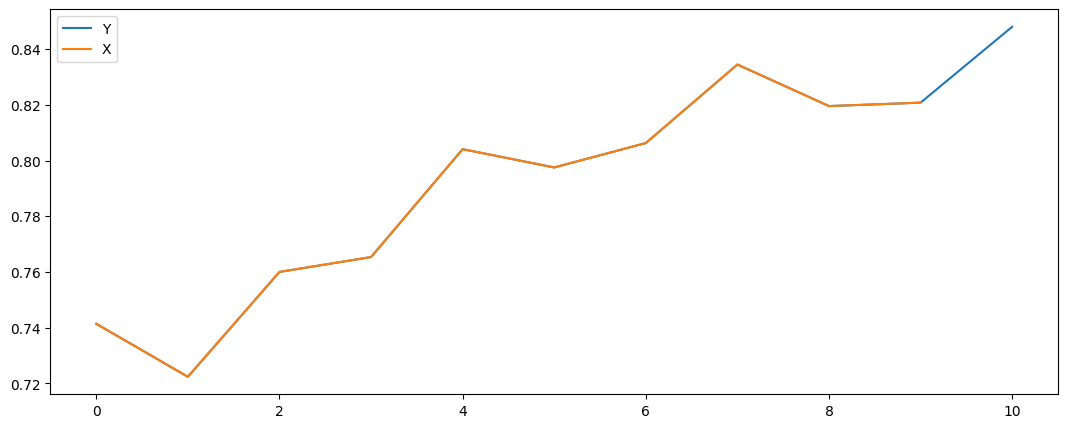

In [9]:
# Plot X and Y
print(X.shape)
print(Y.shape)
for i in range(250,251):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [13]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [15]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")
print(X_train[:1, 0, :])
print(X_test[:1, 0, :])
print(Y_train[:1, :])
print(Y_test[:1, :])

X_train.shape=(342, 10, 6), Y_train.shape=(342, 6)
X_test.shape=(147, 10, 6), Y_test.shape=(147, 6)
[[0.2546869  0.29547674 0.27365107 0.32412107 0.31318908 0.31098447]]
[[0.70323553 0.70494089 0.69518061 0.71323019 0.71277215 0.2380792 ]]
[[0.15011811 0.15059151 0.15735283 0.18128344 0.17291062 0.3438568 ]]
[[0.62477429 0.64662491 0.63092127 0.66972229 0.66973092 0.23371219]]


In [16]:
# # Create the LSTM model
# model = Sequential()
# model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
# model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

def create_model(input_shape: tuple, layers_with_units: list[int] = [128,128,64], optimizer: str = 'adam', loss: str = 'mean_squared_error', metrics: list[str]=['accuracy']) -> Sequential:
    # Create the LSTM model
    model = Sequential()
    for layer in layers_with_units[:-1]:
        model.add(LSTM(layer, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(layers_with_units[-1], return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss, metrics=metrics)
    return model

model = create_model(input_shape=(X_train.shape[1], feature_number))

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=1, verbose=1)

Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0013 - loss: 0.0243 - val_accuracy: 0.0057 - val_loss: 0.0643
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0081 - loss: 0.0215 - val_accuracy: 0.0057 - val_loss: 0.0554
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0016 - loss: 0.0230 - val_accuracy: 0.0057 - val_loss: 0.0504
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 6.0250e-04 - loss: 0.0244 - val_accuracy: 0.0057 - val_loss: 0.0539
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0023 - loss: 0.0216 - val_accuracy: 0.0057 - val_loss: 0.0505
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0056 - loss: 0.0224 - val_accuracy: 0.0057 - val_loss: 0.0501
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 5.8885e-04 - loss: 0.0225 - val_accuracy: 0.0057 - val_loss: 0.0509
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0016 - loss: 0.0203 - val_acc

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


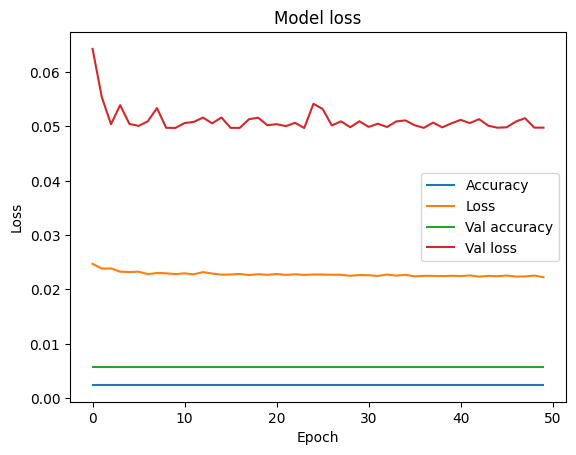

In [22]:
# Plot training & validation loss values
print(history.history.keys())
for value in history.history.keys():
    plt.plot(history.history[value], label=value.replace('_', ' ').capitalize())
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [24]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
# print(train_predict[:2, :])

train_predict.shape=(342, 1), test_predict.shape=(147, 1), Y_train.shape=(342, 6), Y_test.shape=(147, 6)


In [25]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [26]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(342, 1), test_predict.shape=(147, 1), Y_train.shape=(342, 6), Y_test.shape=(147, 6)
[[140.52373476]
 [140.45647252]]


In [27]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")

Train MSE: 33.0212, Test MSE: 70.7006
Train R2 Score: 0.8924, Test R2 Score: 0.1350


time_step=10, X.shape=(489, 10, 6), (len(train_predict) + time_step)=352
test_predict.shape=(147, 1), train_predict.shape=(342, 1), scaled_data.shape=(500, 6)


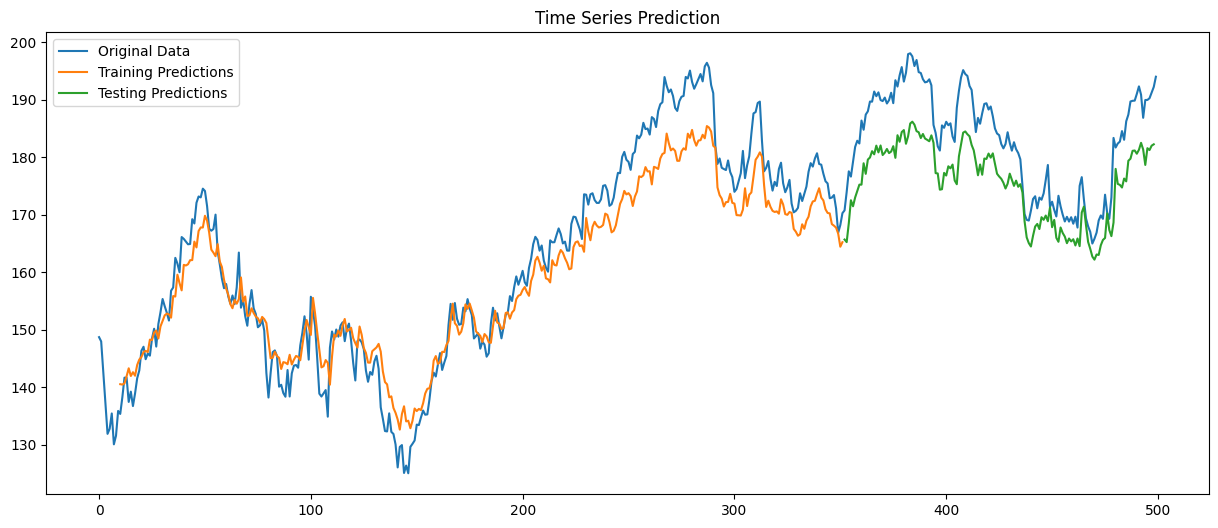

In [28]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [ ]:
model.save('lstm_model_test.h5')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')